# Recommendation System using Collaborative Filtering

In this notebook we will explore recommending system using collaborative filtering


### 1. Load data and preprocessing 

In [731]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import random


In [732]:
orders = pd.read_csv('../data/full_data.csv')

In [733]:
orders.head()

,OrderId,UserId,RestaurantId,Date,Rating,Comments,Address,Count,ItemId,Price,ViewCount,Name,Description,SearchVector,Type
0,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,211,15.0,0.0,Tableside Spinach Salad,NaN,'almond':8 'babi':4 'bacon':11 'jack':10 'mont...,Main
1,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,218,27.0,0.0,King Crab,NaN,'blanc':9 'buerr':8 'caper':7 'char':3 'chilli...,Main
2,293,4,121,2020-05-13 01:20:59.267256,NaN,NaN,NaN,1,440,14.0,1097.0,Joojeh Kabab With Rice,One skewer of chicken breast marinated with yo...,'bbq':14 'chicken':11 'joojeh':1 'juic':9 'kab...,Main
3,294,3,121,2020-05-13 17:34:35.519326,NaN,NaN,NaN,1,455,1.5,9.0,Regular Coffee,NaN,'coffe':2 'regular':1,Drink
4,297,142,121,2020-05-14 00:08:48.756423,NaN,NaN,NaN,1,540,9.9,485.0,Kashk Bademjan,"Barbequed eggplant, lentils, fried onions, gar...",'bademjan':2 'bbq':8 'egg':10 'eggplant':6 'ga...,Main


In [734]:
orders.columns = [c.lower() for c in orders.columns]
orders.columns

Index(['orderid', 'userid', 'restaurantid', 'date', 'rating', 'comments',
       'address', 'count', 'itemid', 'price', 'viewcount', 'name',
       'description', 'searchvector', 'type'],
      dtype='object')

Keep the columns we need

In [735]:
data = orders[['orderid', 'userid', 'date', 'rating','itemid','name']]

Lets keep the user info with some extra added columns to a different datafram

In [736]:
userids = set(data['userid'])
user_info = pd.DataFrame(userids,columns = ['userid']).set_index('userid')

user_info['gender'] = [random.choice(['F','M']) for i in range(user_info.shape[0])]
user_info['age'] = [random.randrange(18,70,1) for i in range(user_info.shape[0])]
user_info.head()

,gender,age
userid,,
1,M,25
3,F,53
4,F,58
5,M,27
26,F,49


Lest add gender and age columns to the order data too

In [737]:
data = pd.merge(data,user_info,left_on='userid',right_on='userid', how ='left')

In [738]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24109 entries, 0 to 24108
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   orderid  24109 non-null  int64  
 1   userid   24109 non-null  int64  
 2   date     24109 non-null  object 
 3   rating   1757 non-null   float64
 4   itemid   24109 non-null  int64  
 5   name     24109 non-null  object 
 6   gender   24109 non-null  object 
 7   age      24109 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 1.7+ MB


As seen above we have not enough ratings for the food. Therefore we compe up with a solution to increase the rate of collabortion with adding a rating to foods that the user has ordered equal to one random choice of 3,4,5. What that means is, that the user is probably liked the food that ordered it, but might not left a comment or rating, also if she ordered it it meanse she liked the ingredient or that food in general.

So lets add that arbitarary rate to the ordered food.

In [739]:
# get the unique number of records
data.nunique()

orderid    10868
userid      4539
date       10868
rating         5
itemid       359
name         320
gender         2
age           52
dtype: int64

Create a column to have random numbers from [3,4,5].

In [740]:
data['random'] = [random.randrange(3, 6, 1) for i in range(data.shape[0])]
print(data['random'].value_counts())

3    8121
4    8035
5    7953
Name: random, dtype: int64


Fill all the NaN values with a record from random column

In [741]:
data['rating'].fillna(value = data['random'], inplace= True)

In [742]:
data['rating'].isna().sum()

0

In [743]:
# remove all the rows with no ratings
# data = data[~(data['rating'].isna())].reset_index()

In [744]:
data['rating'].value_counts()

5.0    8602
4.0    7715
3.0    7666
1.0      90
2.0      36
Name: rating, dtype: int64

In [745]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24109 entries, 0 to 24108
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   orderid  24109 non-null  int64  
 1   userid   24109 non-null  int64  
 2   date     24109 non-null  object 
 3   rating   24109 non-null  float64
 4   itemid   24109 non-null  int64  
 5   name     24109 non-null  object 
 6   gender   24109 non-null  object 
 7   age      24109 non-null  int64  
 8   random   24109 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 1.8+ MB


### Split Data into Train and Test Data

In [746]:
split_perc= int(len(data) * 0.70)
train_data = data[:split_perc]
test_data = data[split_perc:]

### Analysis of Data

/var/folders/pm/804wbvdx4lz30mqcr3mys38r0000gn/T/ipykernel_5890/2780585729.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


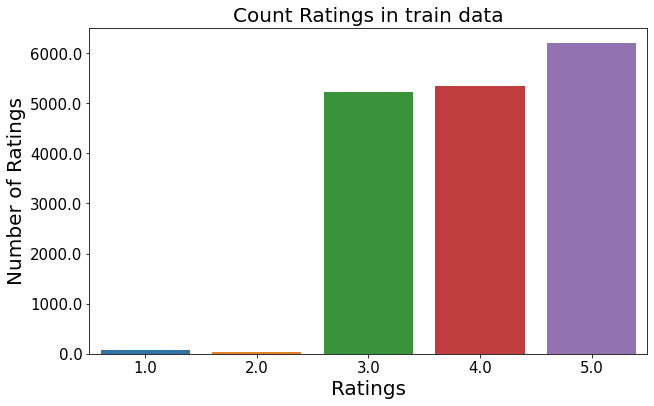

In [747]:
# plot the rating distribution in training data
plt.figure(figsize = (10, 6))
ax = sns.countplot(x="rating", data=train_data)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [748]:
user_rating_no = train_data.groupby("userid")["rating"].count().sort_values(ascending = False)
user_rating_no.head(10)

userid
863     151
1004     64
1629     45
836      42
1628     35
420      34
1184     33
1409     33
1252     33
1276     32
Name: rating, dtype: int64

In [749]:
item_rating_no= train_data.groupby("itemid")["rating"].count().sort_values(ascending = False)
item_rating_no.head(10)

itemid
82659    1583
81555     965
81553     749
81558     745
82674     665
82676     598
81554     470
523       424
81557     375
82658     348
Name: rating, dtype: int64

### Check Cold Start Problem for Users

Here, 28% of total users are new and they will have no proper rating available. So, this can bring the issue of the cold start problems.

In [750]:
total_users = len(np.unique(data["userid"]))
train_users = len(np.unique(train_data["userid"]))
test_users = total_users - train_users
                  
print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data= {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(test_users, np.round((test_users/total_users)*100), 2))

Total no. of Users = 4539
No. of Users in train data= 3210
No. of Users not present in train data = 1329(29.0%)


### Minimal Recommendation Engine V1 : Simple Mean Rating

In [751]:
import numpy as np

In [752]:
def rmse_calculate(y_pred,y_true):
    return np.sqrt(np.nanmean((y_pred - y_true)**2))

def evaluate(prediction_f):
    ids_toestimat = zip(test_data.userid,test_data.itemid)
    estimated = np.array([prediction_f(userid,itemid) for (userid,itemid) in ids_toestimat])
    reals = test_data['rating'].values
    return rmse_calculate(estimated,reals)

def dummy_estimate(userid,itemid):
    return 3    

def content_mean(userid,itemid):
    condition = test_data.userid == userid
    result = test_data.loc[condition][['orderid','userid','itemid','name','rating']]
    #print(result)
    return test_data.loc[condition]['rating'].mean()

def colab_mean(userid,itemid):
    item_condition = test_data.itemid == itemid
    user_condition = test_data.userid != userid
    result = test_data.loc[item_condition & user_condition ][['orderid','userid','itemid','name','rating']]
    #print(result)
    return result['rating'].mean()



In [753]:
userids = list(test_data.userid.values)
items = list(test_data.itemid.values)

userid = random.choice(userids)
itemid = random.choice(items)

print(userid)
print(itemid)

5088
82940


In [754]:

ids_toestimat = zip(test_data.userid,test_data.itemid)
estimated = np.array([colab_mean(userid,itemid) for (userid,itemid) in ids_toestimat])
reals = test_data['rating'].values


print(estimated)
np.sqrt(np.nanmean((estimated - reals)**2))

[4.0617284  4.         4.22727273 ... 4.         3.76       3.8       ]


0.8497355630522

In [755]:
data.rating.isna().sum()

0

In [756]:
evaluate(colab_mean)

0.8497355630522

In [757]:
evaluate(content_mean)

0.7250331121520261

## Pivoting

In [758]:
rating_mtx = pd.pivot_table(train_data,values='rating',index = 'userid',columns ='itemid')

In [759]:
gender_mtx = pd.pivot_table(train_data,values='rating',index = 'itemid',columns ='gender', aggfunc=np.mean)

In [760]:
np.nanmean(gender_mtx['F'].values)

3.9997082000961637

In [761]:
class CollabGenderRec:
    def learn(self):
        self.means_by_gender = pd.pivot_table(train_data,values='rating',index='itemid',columns='gender',aggfunc=np.mean)
   
    def estimate(self,userid,itemid):
        if itemid not in self.means_by_gender.index:
            return 3

        user_gender = user_info.loc[userid]['gender']
        if ~np.isnan(self.means_by_gender.loc[itemid][user_gender]):
            return self.means_by_gender.loc[itemid][user_gender]
        else:
            return self.means_by_gender.loc[itemid].mean()


class CollabAgeRec:
    def learn(self):
        self.means_by_age = pd.pivot_table(train_data,values='rating',index='itemid',columns='age',aggfunc=np.mean)
   
    def estimate(self,userid,itemid):
        if itemid not in self.means_by_age.index:
            return 3

        user_age = user_info.loc[userid]['age']
        if ~np.isnan(self.means_by_age.loc[itemid][user_age]):
            return self.means_by_age.loc[itemid][user_age]
        else:
            return self.means_by_age.loc[itemid].mean()


In [762]:
reco = CollabGenderRec()
reco.learn()
evaluate(reco.estimate)


0.9056870558041474

In [763]:
reco = CollabAgeRec()
reco.learn()
evaluate(reco.estimate)

0.9707881714922196

#### Similarities


In [764]:
def euclidean(s1,s2):
    diff = s1 - s2
    return 1/(1+np.sqrt(np.sum(diff**2)))


In [765]:
def cosine(s1,s2):
    return np.sum(s1*s2)/np.sqrt(np.sum(s1**2)*np.sum(s2**2))


In [766]:
def pearson(s1,s2):
    s1_c = s1-s1.mean()
    s2_c = s2-s2.mean()
    return np.sum(s1_c*s2_c)/np.sqrt(np.sum(s1_c**2)*np.sum(s2_c**2))


In [848]:
class CollabPearsonRec:
    def learn(self):
        self.all_users_profiles = pd.pivot_table(test_data,values='rating',index='userid',columns='itemid',aggfunc=np.mean)
   
    def estimate(self,userid,itemid):
        user_condition = test_data.userid != userid
        item_condition = test_data.itemid == itemid
        rating_by_others = test_data.loc[user_condition & item_condition]
        if rating_by_others.empty:
            return 3

        rating_by_others.set_index('userid',inplace=True)
        their_ids = rating_by_others.index
        their_ratings = rating_by_others.rating
        their_profile = self.all_users_profiles.loc[their_ids]
        user_profile = self.all_users_profiles.loc[userid]
        sims = their_profile.apply(lambda profile: pearson(profile,user_profile), axis=1)
        ratings_sims = pd.DataFrame({'sim':sims,'rating':their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)


In [808]:
evaluate(dummy_estimate)

1.2892262192630226

In [809]:
evaluate(colab_mean)

0.8497355630522

In [810]:
evaluate(content_mean)

0.7250331121520261

In [811]:
rec = CollabAgeRec()
rec.learn()
evaluate(rec.estimate)


0.9707881714922196

In [812]:
rec = CollabGenderRec()
rec.learn()
evaluate(rec.estimate)

0.9056870558041474

In [849]:
rec = CollabPearsonRec()
rec.learn()
evaluate(rec.estimate)


/var/folders/pm/804wbvdx4lz30mqcr3mys38r0000gn/T/ipykernel_5890/2284336235.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(s1_c*s2_c)/np.sqrt(np.sum(s1_c**2)*np.sum(s2_c**2))


0.6503674420971789